**CURSO**: *Machine Learning* en Geociencias<br />
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from [Qixiang Fang and Rens van de Schoot](https://www.rensvandeschoot.com/tutorials/generalised-linear-models-with-brms/).

In [7]:
install.packages("ROCR")

Installing package into 'C:/Users/edier/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)

also installing the dependencies 'bitops', 'caTools', 'gplots'




package 'bitops' successfully unpacked and MD5 sums checked
package 'caTools' successfully unpacked and MD5 sums checked
package 'gplots' successfully unpacked and MD5 sums checked
package 'ROCR' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\edier\AppData\Local\Temp\RtmpiKaKzS\downloaded_packages


# 15: Bayesian (Multilevel) Generalised Linear Models (GLM) in R with brms

In [ ]:
# if you dont have these packages installed yet, please use the install.packages("package_name") command.
library(tidyverse) # for data manipulation and plots
library(haven) #for reading sav data
library(sjstats) #for calculating intra-class correlation (ICC)
library(ROCR) #for calculating area under the curve (AUC) statistics
library(brms) #for Bayesian (multilevel) generalised linear modelling
library(modelr) #for data manipulation
library(tidybayes) #for analysis of posterior draws of a Bayesian model

The data stems from a national survey of primary education in Thailand (Raudenbush & Bhumirat, 1992). Each row in the data refers to a pupil. The outcome variable REPEAT is a dichotomous variable indicating whether a pupil has repeated a grade during primary education. The SCHOOLID variable indicates the school of a pupil. The person-level predictors include: SEX (0 = female, 1 = male) and PPED (having had preschool education, 0 = no, 1 = yes). The school-level is MSESC, representing school mean SES (socio-economic status) scores.

In [4]:
ThaiEdu_Raw <- read_sav("https://github.com/MultiLevelAnalysis/Datasets-third-edition-Multilevel-book/blob/master/chapter%206/Thaieduc/thaieduc.sav?raw=true")
head(ThaiEdu_Raw)

SCHOOLID,SEX,PPED,REPEAT,MSESC
<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>
10101,0,1,0,NA
10101,0,1,0,NA
10101,0,1,0,NA
10101,0,1,0,NA
10101,0,1,0,NA
10101,0,1,0,NA


In [5]:
ThaiEdu_New <- ThaiEdu_Raw %>%
  mutate(SCHOOLID = factor(SCHOOLID),
         SEX = if_else(SEX == 0, "girl", "boy"),
         SEX = factor(SEX, levels = c("girl", "boy")),
         PPED = if_else(PPED == 0, "no", "yes"),
         PPED = factor(PPED, levels = c("no", "yes")))

head(ThaiEdu_New)

SCHOOLID,SEX,PPED,REPEAT,MSESC
<fct>,<fct>,<fct>,<dbl+lbl>,<dbl>
10101,girl,yes,0,NA
10101,girl,yes,0,NA
10101,girl,yes,0,NA
10101,girl,yes,0,NA
10101,girl,yes,0,NA
10101,girl,yes,0,NA


In [6]:
ThaiEdu_New <- ThaiEdu_Raw %>%
  mutate(SCHOOLID = factor(SCHOOLID),
         SEX = if_else(SEX == 0, "girl", "boy"),
         SEX = factor(SEX, levels = c("girl", "boy")),
         PPED = if_else(PPED == 0, "no", "yes"),
         PPED = factor(PPED, levels = c("no", "yes")))

head(ThaiEdu_New)

SCHOOLID,SEX,PPED,REPEAT,MSESC
<fct>,<fct>,<fct>,<dbl+lbl>,<dbl>
10101,girl,yes,0,NA
10101,girl,yes,0,NA
10101,girl,yes,0,NA
10101,girl,yes,0,NA
10101,girl,yes,0,NA
10101,girl,yes,0,NA


In [7]:
ThaiEdu_New %>%
  summarise_each(list(~sum(is.na(.)))) %>%
  gather()

Warning message:
"`summarise_each()` was deprecated in dplyr 0.7.0.
ℹ Please use `across()` instead."


key,value
<chr>,<int>
SCHOOLID,0
SEX,0
PPED,0
REPEAT,0
MSESC,1066


In [8]:
ThaiEdu_New <- ThaiEdu_New %>%
  filter(!is.na(MSESC))

## Bayesian Binary Logistic Regression (with Non-Informative Priors)

In [9]:
ThaiEdu_New %>%
  group_by(SEX) %>%
  summarise(REPEAT = sum(REPEAT))

SEX,REPEAT
<fct>,<dbl>
girl,428
boy,639


In [10]:
ThaiEdu_New %>%
  group_by(PPED) %>%
  summarise(REPEAT = sum(REPEAT))

PPED,REPEAT
<fct>,<dbl>
no,673
yes,394


It seems that the number of pupils who repeated a grade differs quite a bit between the two genders, with more male pupils having to repeat a grade. More pupils who did not have preschool education repeated a grade. This observation suggests that SEX and PPED might be predictive of REPEAT.

The brm function from the brms package performs Bayesian GLM. The brm has three basic arguments that are identical to those of the glm function: formula, family and data. However, note that in the family argument, we need to specify bernoulli (rather than binomial) for a binary logistic regression. The brm function has a few more additional (and necessary) arguments that glm does not offer: warmup specifies the burn-in period (i.e. number of iterations that should be discarded); iter specifies the total number of iterations (including the burn-in iterations); chains specifies the number of chains; inits specifies the starting values of the iterations (normally you can either use the maximum likelihood esimates of the parameters as starting values, or simply ask the algorithm to start with zeros); cores specifies the number of cores used for the algorithm; seed specifies the random seed, allowing for replication of results.

See below the specification of the binary logistic regression model with two predictors, without using informative priors.

In [11]:
Bayes_Model_Binary <- brm(formula = REPEAT ~ SEX + PPED,  
                   data=ThaiEdu_New, 
                   family = bernoulli(link = "logit"),
                   warmup = 500, 
                   iter = 2000, 
                   chains = 2, 
                   inits= "0", 
                   cores=2,
                   seed = 123)

Warning message:
"Argument 'inits' is deprecated. Please use argument 'init' instead."
Compiling Stan program...

Start sampling



Before looking at the model summary, we should check whether there is evidence of non-convergence for the two chains. To do so, we can use the stanplot function from the brms package.

First, we plot the caterpillar plot for each parameter of interest.

Warning message:
"Method 'stanplot' is deprecated. Please use 'mcmc_plot' instead."
No divergences to plot.


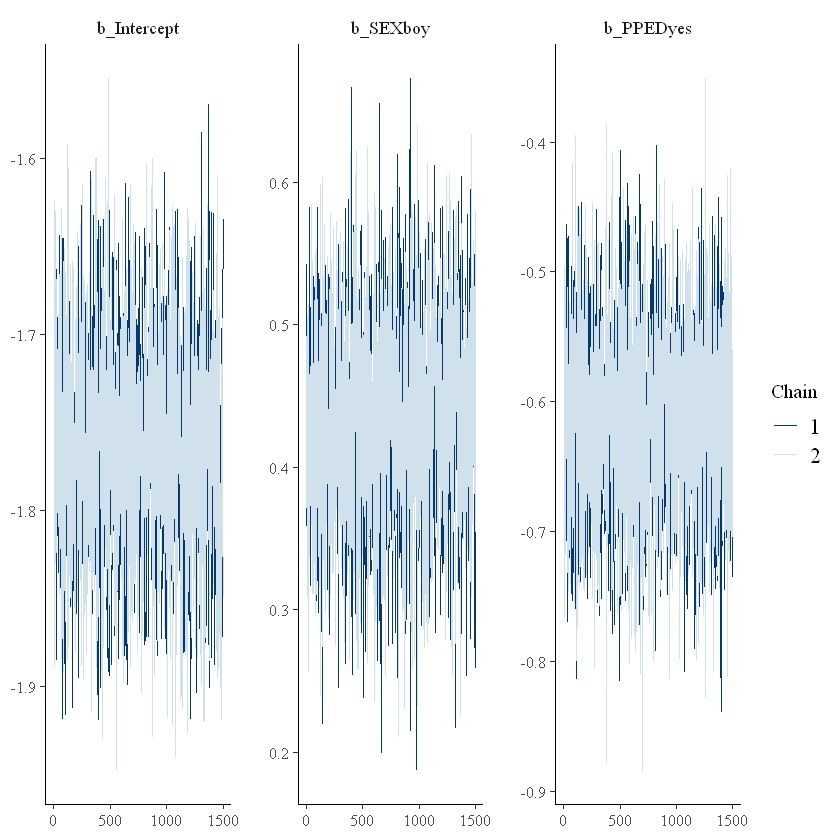

In [12]:
stanplot(Bayes_Model_Binary, 
         type = "trace")

The plot only shows the iterations after the burn-in period. The two chains mix well for all of the parameters and therefore, we can conclude no evidence of non-convergence.

We can also check autocorrelation, considering that the presence of strong autocorrelation would bias variance estimates.

Warning message:
"Method 'stanplot' is deprecated. Please use 'mcmc_plot' instead."
Warning message:
"The `facets` argument of `facet_grid()` is deprecated as of ggplot2 2.2.0.
ℹ Please use the `rows` argument instead.
ℹ The deprecated feature was likely used in the bayesplot package.
  Please report the issue at <https://github.com/stan-dev/bayesplot/issues/>."


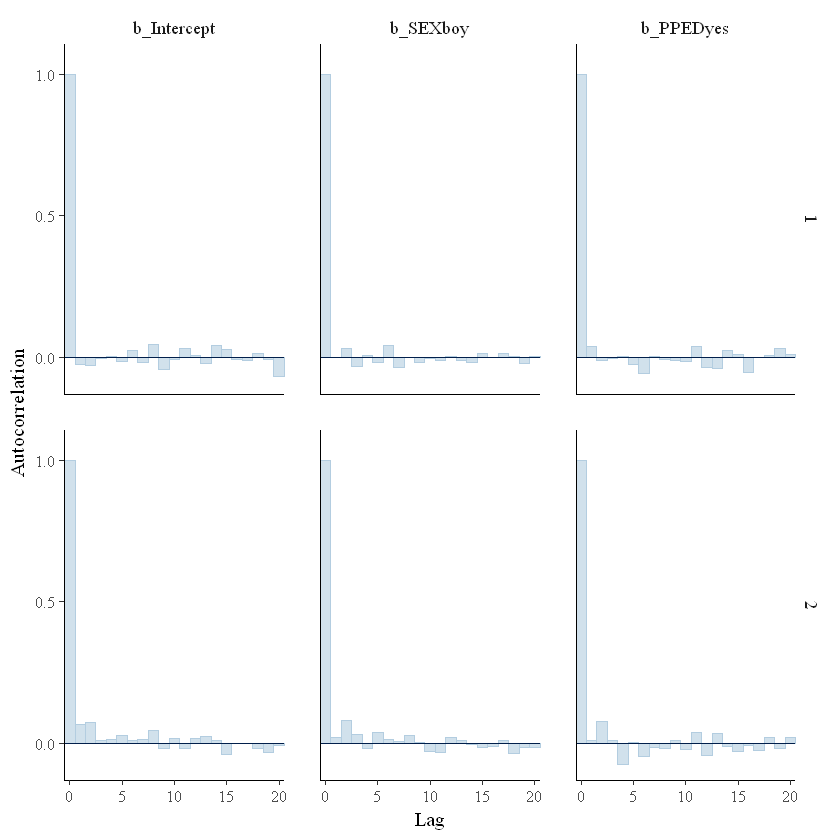

In [13]:
stanplot(Bayes_Model_Binary, 
         type = "acf_bar")

The plot shows no evidence of autocorrelation for all model variables in both chains, as the autocorrelation parameters all quickly diminish to around zero.

Now, we can safely proceed to the interpretation of the model. Below is the model summary of the Bayesian binary logistic regression model.

In [14]:
summary(Bayes_Model_Binary)

 Family: bernoulli 
  Links: mu = logit 
Formula: REPEAT ~ SEX + PPED 
   Data: ThaiEdu_New (Number of observations: 7516) 
  Draws: 2 chains, each with iter = 2000; warmup = 500; thin = 1;
         total post-warmup draws = 3000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -1.76      0.06    -1.88    -1.65 1.00     2454     2272
SEXboy        0.43      0.07     0.29     0.57 1.00     2635     2099
PPEDyes      -0.61      0.07    -0.75    -0.47 1.00     2662     2045

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

For comparison, below is the model summary of the frequentist binary logistic regression model.

In [ ]:
Model_Binary <- glm(formula = REPEAT ~ SEX + PPED,
                    family = binomial(link = "logit"),
                    data = ThaiEdu_New)
summary(Model_Binary)

From the model summary above, we can see that the Bayesian model estimates are almost identical to those of the frequentist model. The interpretation of these estimates are the same in both frequentist and Bayesian models. Nevertheless, note that the interpretation of the uncertainty intervals is not the same between the two models. In the frequentist model, the idea behind using a 95% uncertainty interval (confidence interval) is that, under repeated sampling, 95% of the resulting uncertainy intervals would cover the true population value. That allows us to say that, for a given 95% confidence interval, we are 95% confident that this confidence interval contains the true population value. However, it does not allow us to say that there is a 95% chance that the confidence interval contains the true population value (i.e. frequentist uncertainty intervals are not probability statements). In contrast, in the Bayesian model, the 95% uncertainty interval (called credibility interval), which is more interpretable, states that there is 95% chance that the true population value falls within this interval. When the 95% credibility intervals do not contain zero, we conclude that the respective model parameters are likely meaningful.

Let’s visualise the point estimates and their associated uncertainty intervals, using the stanplot function.

Warning message:
"Method 'stanplot' is deprecated. Please use 'mcmc_plot' instead."


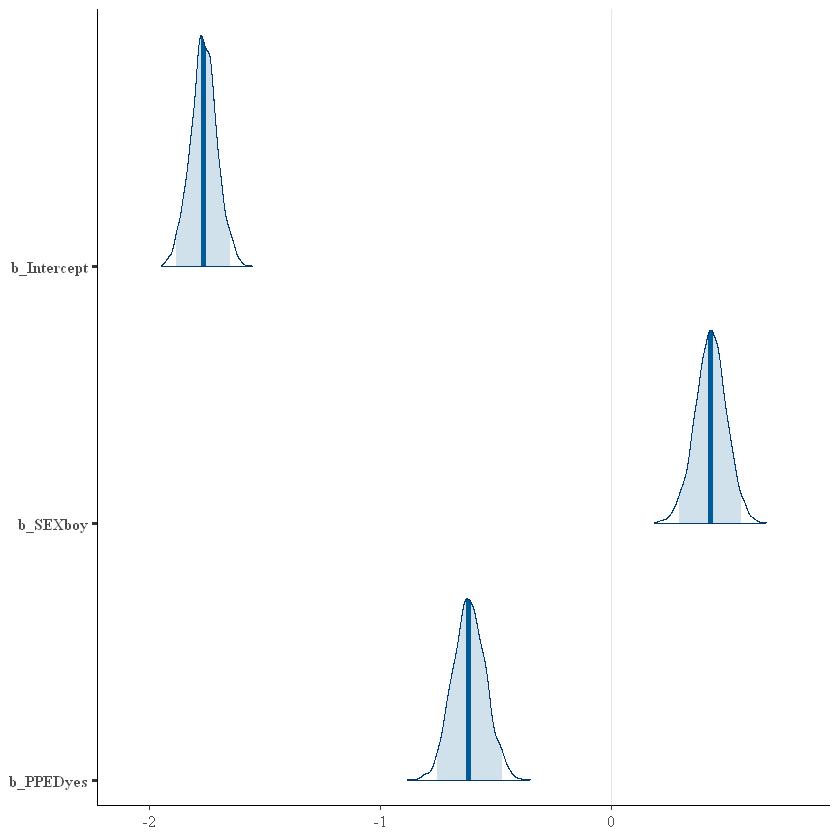

In [15]:
stanplot(Bayes_Model_Binary, 
         type = "areas",
         prob = 0.95)

The plot above shows the densities of the parameter estimates. The dark blue line in each density represents the point estimate, while the light-blue area indicates the 95% credibility intervals. We can easily see that both SEX and PPED are meaningful predictors, as their credibility intervals do not contain zero and their densities have a very narrow shape. SEX positively predicts a pupil’s probability of repeating a grade, while PPED negatively so. Specifically, in comparison to being a girl, being a boy is more likely to repeat a grade, assuming everything else stays constant. Having previous schooling is less likely to result in repeating a grade, assuming everything else stays constant.

To interpret the value of the parameter estimates, we need to exponentiate the estimates. See below.

In [16]:
exp(fixef(Bayes_Model_Binary)[,-2])

,Estimate,Q2.5,Q97.5
Intercept,0.1713116,0.1525777,0.1926691
SEXboy,1.5397405,1.3417948,1.7605666
PPEDyes,0.5409237,0.4724289,0.6234184


Warning message:
"Method 'stanplot' is deprecated. Please use 'mcmc_plot' instead."


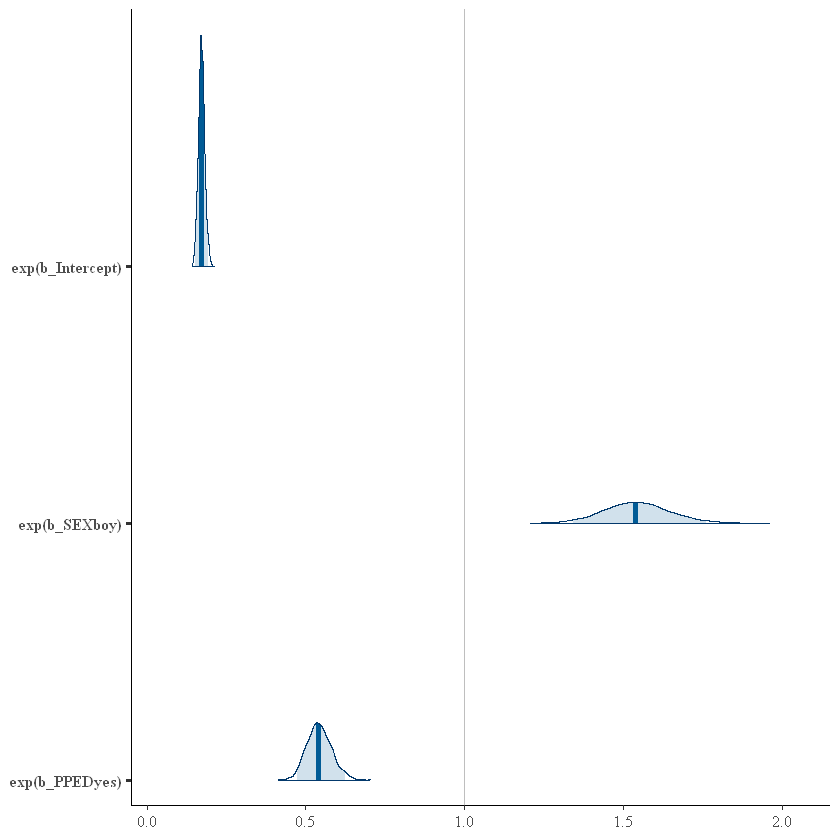

In [17]:
stanplot(Bayes_Model_Binary, 
         type = "areas",
         prob = 0.95,
         transformations = "exp") +
  geom_vline(xintercept = 1, color = "grey")

Note that the interpretation of the parameter estimates is linked to the odds rather than probabilities. The definition of odds is: P(event occurring)/P(event not occurring). In this analysis, assuming everything else stays the same, being a boy increases the odds of repeating a grade by 54%, in comparison to being a girl; having preschool education lowers the odds of repeating a grade by (1 – 0.54)% = 46%, in comparison to not having preschool education, assuming everything else stays constant. The baseline odds (indicated by the intercept term) of repeating a grade, namely if you’re a girl with no previous schooling, is about 17%.

We can plot the marginal effects (i.e. estimated probabilities of repeating a grade) of the variables in the model. Below, we show how different combinations of SEX and PPED result in different probability estimates. The advantage of this approach is that probabilities are more interpretable than odds.

In [18]:
ThaiEdu_New %>%
  data_grid(SEX, PPED) %>%
  add_fitted_draws(Bayes_Model_Binary) %>%
  ggplot(aes(x = .value, y = interaction(SEX, PPED))) +
  stat_pointintervalh(.width = c(.68, .95)) +
  coord_flip() +
  xlab("predicted probability") +
  scale_x_continuous(breaks = seq(0, 0.24, 0.02))

ERROR: Error in add_fitted_draws(., Bayes_Model_Binary): could not find function "add_fitted_draws"


As we can see, being a male pupil with no preschool education has the highest probability (~0.21), followed by being a girl with no preschool education (~0.15), being a boy with preschool education (~0.13), and lastly, being a girl with preschool education (~0.09). Note that both 68% (thicker inner lines) and 95% (thinner outer lines) credibility intervals for the estimates are included to give us some idea of the uncertainties of the estimates.

In the Intro to Frequentist (Multilevel) Generalised Linear Models (GLM) in R with glm and lme4 tutorial, we learn that we can use the likelihood ratio test and AIC to assess the goodness of fit of the model(s). However, these two approaches do not apply to Bayesian models. Instead, Bayesian models make use of so-called Posterior Predictive P-values (PPPs) to assess the fit of the model. In addition, many also use Bayes factors to quantify support from the data for the model. This tutorial does not delve into PPPs or Bayes factors because of the complexity of the topics.

The other two measures mentioned in Intro to Frequentist (Multilevel) Generalised Linear Models (GLM) in R with glm and lme4 are correct classification rate and area under the curve (AUC). They are model-agnostic, meaning they can be applied to both frequentist and Bayesian models.

The percentage of correct classification is a useful measure to see how well the model fits the data.

In [19]:
#use the `predict()` function to calculate the predicted probabilities of pupils in the original data from the fitted model
Pred <- predict(Bayes_Model_Binary, type = "response")
Pred <- if_else(Pred[,1] > 0.5, 1, 0)
ConfusionMatrix <- table(Pred, pull(ThaiEdu_New, REPEAT)) #`pull` results in a vector
#correct classification rate
sum(diag(ConfusionMatrix))/sum(ConfusionMatrix)

[1] 0.8580362

We can see that the model correctly classifies 85.8% of all the observations. However, a closer look at the confusion matrix reveals that the model predicts all of the observations to belong to class “0”, meaning that all pupils are predicted not to repeat a grade. Given that the majority category of the REPEAT variable is 0 (No), the model does not perform better in classification than simply assigning all observations to the majority class 0 (No).

In [20]:
ConfusionMatrix

    
Pred    0    1
   0 6449 1067

An alternative to using correct classification rate is the Area under the Curve (AUC) measure. The AUC measures discrimination, that is, the ability of the test to correctly classify those with and without the target response. In the current data, the target response is repeating a grade. We randomly pick one pupil from the “repeating a grade” group and one from the “not repeating a grade” group. The pupil with the higher predicted probability should be the one from the “repeating a grade” group. The AUC is the percentage of randomly drawn pairs for which this is true. This procedure sets AUC apart from the correct classification rate because the AUC is not dependent on the imblance of the proportions of classes in the outcome variable. A value of 0.50 means that the model does not classify better than chance. A good model should have an AUC score much higher than 0.50 (preferably higher than 0.80).

In [21]:
# Compute AUC for predicting Class with the model
Prob <- predict(Bayes_Model_Binary, type="response")
Prob <- Prob[,1]
Pred <- prediction(Prob, as.vector(pull(ThaiEdu_New, REPEAT)))
AUC <- performance(Pred, measure = "auc")
AUC <- AUC@y.values[[1]]
AUC

[1] 0.6004406

## Bayesian Binomial Logistic Regression (with Non-Informative Priors)

As explained in the Intro to Frequentist (Multilevel) Generalised Linear Models (GLM) in R with glm and lme4 tutorial, logistic regression can also be used to model count or proportion data. Binary logistic regression assumes that the outcome variable comes from a bernoulli distribution (which is a special case of binomial distributions) where the number of trial n
 is 1 and thus the outcome variable can only be 1 or 0. In contrast, binomial logistic regression assumes that the number of the target events follows a binomial distribution with n
 trials and probability q
. In this way, binomial logistic regression allows the outcome variable to take any non-negative integer value and thus is capable of handling count data.

The Thai Educational Data records information about individual pupils that are clustered within schools. By aggregating the number of pupils who repeated a grade by school, we obtain a new data set where each row represents a school, with information about the proportion of pupils repeating a grade in that school. The MSESC (mean SES score) is also on the school level; therefore, it can be used to predict proportion or count of pupils who repeat a grade in a particular school. See below.

In [22]:
ThaiEdu_Prop <- ThaiEdu_New %>%
  group_by(SCHOOLID, MSESC) %>%
  summarise(REPEAT = sum(REPEAT),
            TOTAL = n()) %>%
  ungroup()

head(ThaiEdu_Prop)

`summarise()` has grouped output by 'SCHOOLID'. You can override using the `.groups` argument.


SCHOOLID,MSESC,REPEAT,TOTAL
<fct>,<dbl>,<dbl>,<int>
10103,0.88,1,17
10104,0.20,0,29
10105,-0.07,5,18
10106,0.47,0,5
10108,0.76,3,19
10109,1.06,9,21


In this new data set, REPEAT refers to the number of pupils who repeated a grade; TOTAL refers to the total number of students in a particular school.

`geom_smooth()` using formula = 'y ~ x'


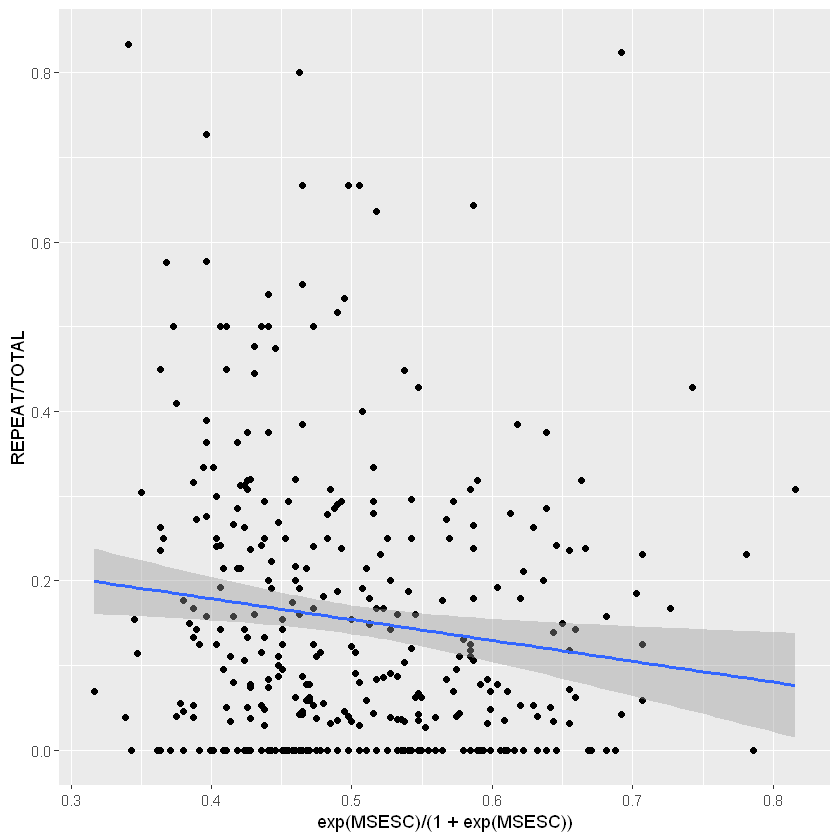

In [24]:
ThaiEdu_Prop %>%
  ggplot(aes(x = exp(MSESC)/(1+exp(MSESC)), y = REPEAT/TOTAL)) +
  geom_point() +
  geom_smooth(method = "lm")

We can see that the proportion of students who repeated a grade is (moderately) negatively related to the inverse-logit of MSESC. Note that we model the variable MSESC as its inverse-logit because in a binomial regression model, we assume a linear relationship between the inverse-logit of the linear predictor and the outcome (i.e. proportion of events), not linearity between the predictor itself and the outcome.

To fit a Bayesian binomial logistic regression model, we also use the brm function like we did with the previous Bayesian binary logistic regression model. There are, however, two differences: First, to specify the outcome variable in the formula, we need to specify both the number of target events (REPEAT) and the total number of trials (TOTAL) wrapped in trials(), which are separated by |. In addition, the family should be “binomial” instead of “bernoulli”.

In [25]:
Bayes_Model_Prop <- brm(REPEAT | trials(TOTAL) ~ MSESC,  
                        data = ThaiEdu_Prop, 
                        family = binomial(link = "logit"),
                        warmup = 500, 
                        iter = 2000, 
                        chains = 2, 
                        inits = "0", 
                        cores = 2,
                        seed = 123)

summary(Bayes_Model_Prop)

Warning message:
"Argument 'inits' is deprecated. Please use argument 'init' instead."
Compiling Stan program...

Start sampling



The frequentist model (for comparison):

In [26]:
Model_Prop <- glm(formula = cbind(REPEAT, TOTAL-REPEAT) ~ MSESC,
                  family = binomial(logit),
                  data = ThaiEdu_Prop)

summary(Model_Prop)


Call:
glm(formula = cbind(REPEAT, TOTAL - REPEAT) ~ MSESC, family = binomial(logit), 
    data = ThaiEdu_Prop)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.80434    0.03324 -54.280  < 2e-16 ***
MSESC       -0.43644    0.09164  -4.763 1.91e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1480.7  on 355  degrees of freedom
Residual deviance: 1457.3  on 354  degrees of freedom
AIC: 2192

Number of Fisher Scoring iterations: 5


We can see that the model estimates between the Bayesian and the frequentist binomial logistic regression models are very similar. Note that we skipped the step of checking model convergence, for the sake of keeping this tutorial shorter. You can use the same codes we showed before (with the binary logistic regression model) to check the convergence of this model.

The parameter interpretation in a binomial regression model is the same as that in a binary logistic regression model. We know from the model summary above that the mean SES score of a school is negatively related to the odds of students repeating a grade in that school. To enhance interpretability, we again calculate the exponentiated coefficient estimate of MSESC. Since MSESC is a continous variable, we can standardise the exponentiated MSESC estimate (by multiplying the original estimate with the SD of the variable, and then then exponentiating the resulting number).

In [27]:
exp(fixef(Bayes_Model_Prop)[2,-2]*sd(pull(ThaiEdu_Prop, MSESC), na.rm = T))

Estimate      Q2.5     Q97.5 
0.8466877 0.7899909 0.9043975

We can see that with a SD increase in MSESC, the odds of students repeating a grade is lowered by about (1 – 85%) = 15%. “Q2.5” and “Q97.5” refer to the lower bound and the upper bound of the uncertainty interval, respectively. This credibility interval does not contain zero, suggesting that the variable is likely meaningful.

We can visualise the effect of MSESC.

In [28]:
Bayes_Model_Prop %>%
  spread_draws(b_Intercept, b_MSESC) %>%
  mutate(MSESC = list(seq(-0.77, 1.49, 0.01))) %>% #the observed value range of MSESC
  unnest(MSESC) %>%
  mutate(pred = exp(b_Intercept + b_MSESC*MSESC)/(1+exp(b_Intercept + b_MSESC*MSESC))) %>%
  group_by(MSESC) %>%
  summarise(pred_m = mean(pred, na.rm = TRUE),
            pred_low = quantile(pred, prob = 0.025),
            pred_high = quantile(pred, prob = 0.975)) %>%
  ggplot(aes(x = MSESC, y = pred_m)) +
  geom_line() +
  geom_ribbon(aes(ymin = pred_low, ymax = pred_high), alpha=0.2) +
  ylab("Predicted Probability of Repeating a Grade") +
  scale_y_continuous(breaks = seq(0, 0.22, 0.01))

ERROR: Error in spread_draws(., b_Intercept, b_MSESC): could not find function "spread_draws"


The plot above shows the expected influence of MSESC on the probability of a pupil repeating a grade. Holding everything else constant, as MSESC increases, the probability of a pupil repeating a grade lowers (from 0.19 to 0.08). The grey shaded areas indicate the 95% credibility intervals of the predicted values at each value of MSESC.

Similar to the Bayesian binary logistic regression model, we can use the PPPS and Bayes factor (which are not discussed in this tutorial) to evaluate the fit of a Bayesian binomial logistic regression model. Correct classification rate and AUC are not suited here, as the model is not concerned with classification.

## Bayesian Multilevel Binary Logistic Regression (with Non-Informative Priors)

The Bayesian binary logistic regression model introduced earlier is limited to modelling the effects of pupil-level predictors; the Bayesian binomial logistic regression is limited to modelling the effects of school-level predictors. To incorporate both pupil-level and school-level predictors, we can use multilevel models, specifically, Bayesian multilevel binary logistic regression. If you are unfamiliar with multilevel models, you can use Multilevel analysis: Techniques and applications for reference and this tutorial for a good introduction to multilevel models with the lme4 package in R.

In addition to the motivation above, there are more reasons to use multilevel models. For instance, as the data are clustered within schools, it is likely that pupils from the same school are more similar to each other than those from other schools. Because of this, in one school, the probability of a pupil repeating a grade may be high, while in another school, low. Furthermore, even the relationship between the outcome (i.e. repeating a grade) and the predictor variabales (e.g. gender, preschool education, SES) may be different across schools. Also note that there are missing values in the MSESC variable. Using multilevel models can appropriately address these issues.

See the following plot as an example. The plot shows the proportions of students repeating a grade across schools. We can see vast differences across schools. Therefore, we need multilevel models.

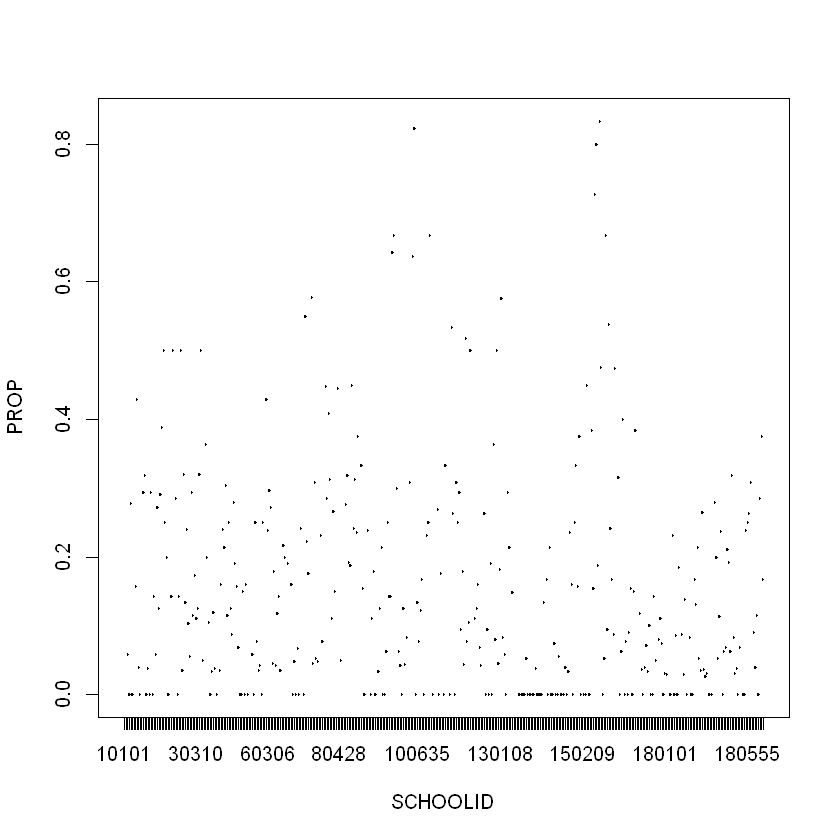

In [29]:
ThaiEdu_New %>%
  group_by(SCHOOLID) %>%
  summarise(PROP = sum(REPEAT)/n()) %>%
  plot()

We can also plot the relationship between SEX and REPEAT by SCHOOLID, to see whether the relationship between gender and repeating a grade differs by school.



`geom_smooth()` using formula = 'y ~ x'


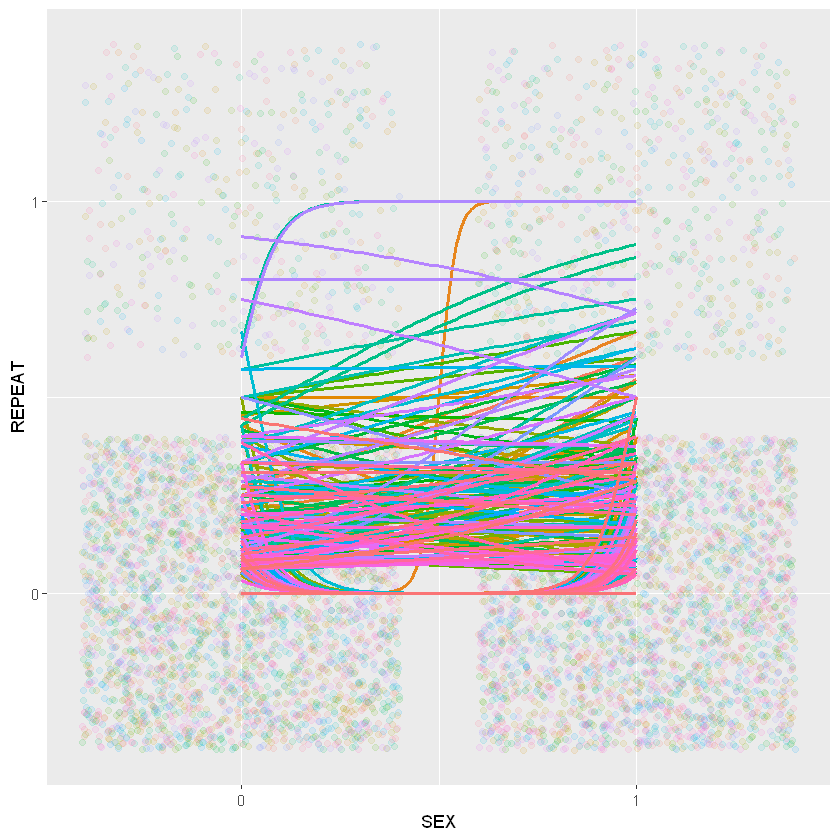

In [30]:
ThaiEdu_New %>%
  mutate(SEX = if_else(SEX == "boy", 1, 0)) %>%
  ggplot(aes(x = SEX, y = REPEAT, color = as.factor(SCHOOLID))) +
  geom_point(alpha = .1, position = "jitter")+
  geom_smooth(method = "glm", se = F, 
              method.args = list(family = "binomial")) +
  theme(legend.position = "none") +
  scale_x_continuous(breaks = c(0, 1)) +
  scale_y_continuous(breaks = c(0, 1))

In the plot above, different colors represent different schools. We can see that the relationship between SEX and REPEAT appears to be quite different across schools.

We can make the same plot for PPED and REPEAT.

`geom_smooth()` using formula = 'y ~ x'


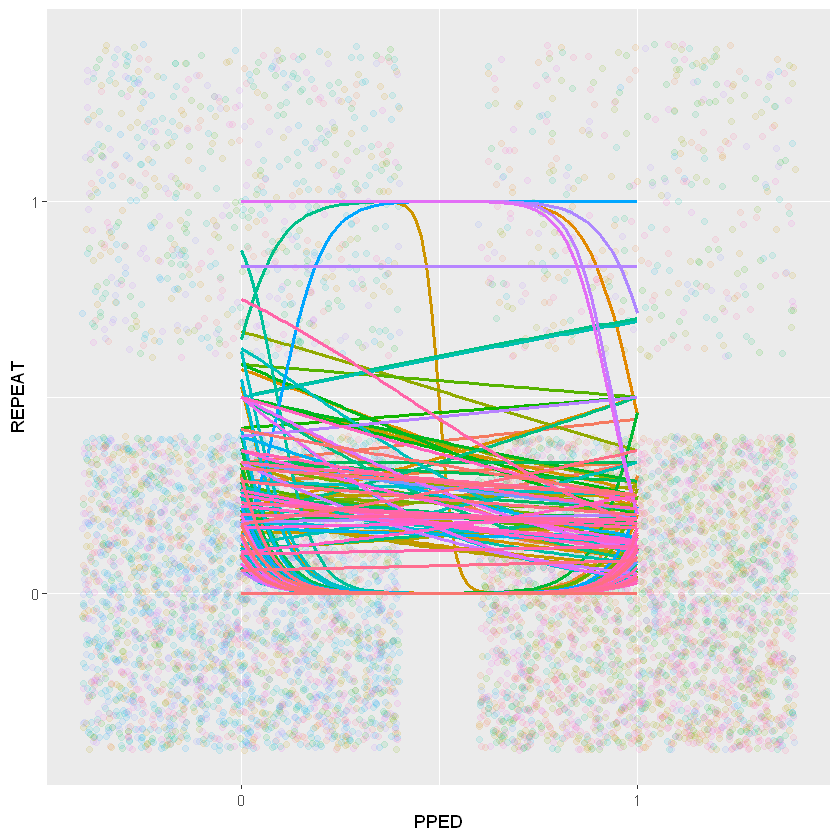

In [31]:
ThaiEdu_New %>%
  mutate(PPED = if_else(PPED == "yes", 1, 0)) %>%
  ggplot(aes(x = PPED, y = REPEAT, color = as.factor(SCHOOLID))) +
  geom_point(alpha = .1, position = "jitter")+
  geom_smooth(method = "glm", se = F, 
              method.args = list(family = "binomial")) +
  theme(legend.position = "none") +
  scale_x_continuous(breaks = c(0, 1)) +
  scale_y_continuous(breaks = c(0, 1))

The relationship between PPED and REPEAT also appears to be quite different across schools. However, we can also see that most of the relationships follow a downward trend, going from 0 (no previous schooling) to 1 (with previous schooling), indicating a negative relationship between PPED and REPEAT.

Because of the observations above, we can conclude that there is a need for multilevel modelling in the current data, with not only a random intercept (SCHOOLID) but potentially also random slopes of the SEX and PPED.

Prior to fitting a multilevel model, it is necessary to center the predictors by using an appropriately chosen centering method (i.e. grand-mean centering or within-cluster centering), because the centering approach matters for the interpretation of the model estimates. Following the advice of Enders and Tofighi (2007), we should use within-cluster centering for the first-level predictors SEX and PPED, and grand-mean centering for the second-level predictor MSESC.

In [32]:
ThaiEdu_Center <- ThaiEdu_New %>%
  mutate(SEX = if_else(SEX == "girl", 0, 1),
         PPED = if_else(PPED == "yes", 1, 0)) %>%
  group_by(SCHOOLID) %>%
  mutate(SEX = SEX - mean(SEX),
         PPED = PPED - mean(PPED)) %>%
  ungroup() %>%
  mutate(MSESC = MSESC - mean(MSESC, na.rm = T))

head(ThaiEdu_Center)

SCHOOLID,SEX,PPED,REPEAT,MSESC
<fct>,<dbl>,<dbl>,<dbl+lbl>,<dbl>
10103,-0.6470588,-0.8823529,0,0.870326
10103,-0.6470588,-0.8823529,0,0.870326
10103,-0.6470588,0.1176471,0,0.870326
10103,-0.6470588,0.1176471,0,0.870326
10103,-0.6470588,0.1176471,0,0.870326
10103,-0.6470588,0.1176471,0,0.870326


### Intercept Only Model

o specify a multilevel model, we again use the brm function from the brms package. Note that the random effect term should be included in parentheses. In addition, within the parentheses, the random slope term(s) and the cluster terms should be separated by |.

We start by specifying an intercept-only model, in order to assess the impact of the clustering structure of the data. Note that we will skip the step of model convergence diagnostics.

In [33]:
Bayes_Model_Multi_Intercept <- brm(REPEAT ~ 1 + (1|SCHOOLID),
                                   data = ThaiEdu_Center, 
                                   family = bernoulli(link = "logit"),
                                   warmup = 500, 
                                   iter = 2000, 
                                   chains = 2, 
                                   inits = "0", 
                                   cores = 2,
                                   seed = 123)

Warning message:
"Argument 'inits' is deprecated. Please use argument 'init' instead."
Compiling Stan program...

Start sampling



elow we calculate the ICC (intra-class correlation) of the intercept-only model. Note that for non-Gaussian Bayesian models (e.g. logistic regression), we need to set “ppd = T” such that the variance calculation is based on the posterior predictive distribution.

In [34]:
icc(Bayes_Model_Multi_Intercept, ppd = T)

ERROR: Error in icc(Bayes_Model_Multi_Intercept, ppd = T): unused argument (ppd = T)


A variance ratio (comparable to ICC) of 0.29 means that 29% of the variation in the outcome variable can be accounted for by the clustering stucture of the data. This provides evidence that a multilevel model may make a difference to the model estimates, in comparison with a non-multilevel model. Therefore, the use of multilevel models is necessary and warrantied.

### Full model

It is good practice to build a multilevel model step by step. However, as this tutorial’s focus is not on muitilevel modelling, we go directly from the intercept-only model to the full-model that we are ultimately interested in. In the full model, we include not only fixed effect terms of SEX, PPED and MSESC and a random intercept term, but also random slope terms for SEX and PPED. Note that we specify family = bernoulli(link = "logit"), as this model is essentially a binary logistic regression model.

In [ ]:
Bayes_Model_Multi_Full <- brm(REPEAT ~ SEX + PPED + MSESC + (1 + SEX + PPED|SCHOOLID),
                          data = ThaiEdu_Center, 
                          family = bernoulli(link = "logit"),
                          warmup = 500, 
                          iter = 2000, 
                          chains = 2, 
                          inits = "0", 
                          cores = 2,
                          seed = 123)

summary(Bayes_Model_Multi_Full)

In [ ]:
stanplot(Bayes_Model_Multi_Full, 
         type = "areas",
         prob = 0.95)

In [ ]:
The results (pertaining to the fixed effects) are similar to the results of the previous Bayesian binary logistic regression and binomial logistic regression models. On the pupil-level, SEX has a positive influence on the odds of a pupil repeating a grade, while PPED has a negative influence. On the school-level, MSESC has a negative effect on the outcome variable. Among three predictors, SEX and PPED have credibility intervals (indicated by the shaded light blue regions in the densities) that clearly do not contain zero. Therefore, they should be treated as meaningful predictors. In contrast, MSESC, despite having a 95% credibility interval without zero, the upper bound of the credibility interval is very close to zero, and its density only contains zero. Because of this, MSESC is likely a less relevant predictor than SEX and PPED.

Now let’s look at the random effect terms (sd(Intercept), sd(SEX) and sd(PPED)). The density of sd(Intercept) in the plot is clearly away from zero, indicating the relevance of including this random intercept term in the model. The variance of the random slope of SEX is 0.382=0.14
, and that of PPED is 0.262=0.07
. Both variances are not negligible. However, if we look at the density plot, the lower bounds of the credibility intervals of both sd(SEX) and sd(PPED) are very close to zero, and their densities also not clearly separate from zero. This suggests that including these two random slope terms may not be necessary.

We can also plot the random effect terms across schools.

In [ ]:
#extract posterior distributions of all the random effect terms
data_RandomEffect <- ranef(Bayes_Model_Multi_Full)

#extract posterior distributions of `sd(Intercept)`
r_Intercept <- data_RandomEffect$SCHOOLID[, , 1] %>%
  as_tibble() %>%
  rownames_to_column(var = "SCHOOLID") %>%
  mutate(Variable = "sd(Intercept)")

#extract posterior distributions of `sd(SEX)`
r_SEX <- data_RandomEffect$SCHOOLID[, , 2] %>%
  as_tibble() %>%
  rownames_to_column(var = "SCHOOLID") %>%
  mutate(Variable = "sd(SEX)")

#extract posterior distributions of `sd(PPED)`
r_PPED <- data_RandomEffect$SCHOOLID[, , 3] %>%
  as_tibble() %>%
  rownames_to_column(var = "SCHOOLID") %>%
  mutate(Variable = "sd(PPED)")

#plot
r_Intercept %>%
  bind_rows(r_SEX) %>%
  bind_rows(r_PPED) %>%
  mutate(Contain_Zero = if_else(Q2.5*Q97.5 > 0, "no", "yes")) %>%
  ggplot(aes(x = SCHOOLID, y = Estimate, col = Contain_Zero)) +
  geom_point() +
  geom_errorbar(aes(ymin=Q2.5, ymax=Q97.5)) +
  facet_grid(. ~ Variable, scale = "free") +
  coord_flip() +
  theme(legend.position = "top")

Again, we can see that the posterior distributions of the random intercept term (sd(Intercept)) have a large variance across schools. Quite a number of them are also away from zero. Therefore, we can conclude that the inclusion of the random intercept is necessary. In comparison, all of the posterior distributions of sd(SEX) and sd(PPED) go through zero, suggesting that there is probably no need to include the two random slopes in the model.

To interpret the fixed-effect terms, we can calculate the exponentiated coefficient estimates.

In [ ]:
#the categorical variables: SEX and PPED
exp(fixef(Bayes_Model_Multi_Full)[-4,-2])

In [ ]:
#the continous variable: MSESC
exp(fixef(Bayes_Model_Multi_Full)[4,-2]*sd(pull(ThaiEdu_Prop, MSESC), na.rm = T))

In [ ]:
We can see that the effects of SEX, PPED, and MSESC are very similar to the prevoius model results.